In [1]:
# -*- coding: utf-8 -*-
import os
import time
import ogr2ogr
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from fiona.errors import DriverError
from fiona.drvsupport import supported_drivers
from configparser import ConfigParser
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import shutil

# 為cartpy0.17bug暫時添加
import six
from PIL import Image



file_shp 發現檔案:
台灣_縣市界線

file_csv 發現檔案:
沒有發現任何檔案

file_kml 發現檔案:
沒有發現任何檔案

file_asc 發現檔案:
dm1d0300

讀取檔案: 台灣_縣市界線.shp
原座標系統： +init=epsg:4326 +type=crs
轉換為： epsg:4326
  COUNTYID COUNTYCODE COUNTYNAME          COUNTYENG  \
0        Z      09007          蝮  Lienchiang County   
1        G      10002       摰蝮       Yilan County   
2        N      10007        敶啣蝮    Changhua County   
3        M      10008         蝮      Nantou County   
4        P      10009         脫蝮      Yunlin County   

                                            geometry  
0  MULTIPOLYGON (((119.96445 25.94552, 119.96427 ...  
1  MULTIPOLYGON (((121.95971 24.84494, 121.96064 ...  
2  POLYGON ((120.45655 24.20719, 120.48589 24.197...  
3  POLYGON ((121.27086 24.23661, 121.27108 24.236...  
4  MULTIPOLYGON (((120.08108 23.52412, 120.08161 ...  

讀取檔案: dm1d0300.asc
BoundingBox(left=154922.5, bottom=2545734.5, right=173482.5, top=2558334.5)
cellSize(x,y):  (20.0, 20.0)
shape:  928 cols, 630 rows
轉換為： EPSG:4326


C:\Users\cvb14\anaconda3\envs\PyGIS_ExportPic\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


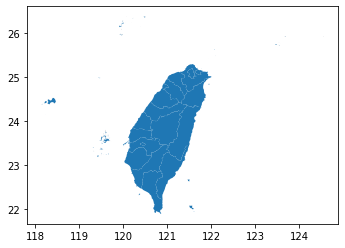

In [2]:
read_files = []
read_colors = []
file_set = []
df_set = []
raster_set = []
color_set = []
i = 0
# 副檔名
ext = []
# 建立傳給gp.read_file的額外參數 (csv用)
options = {}
cfg = ConfigParser()
cfg.read('config.ini', encoding='utf-8-sig')
# 由ini讀入各格式檔名
for section in cfg.sections():
    read_files.append(cfg[section]['name'])
    read_colors.append(cfg[section]['color'])
    if read_colors[i] != "":
        cs = read_colors[i].split(',')
        for c in cs:
            c.strip()
            # 讀到colormap時
            if not c.startswith('#'):
                cmap = plt.get_cmap(c)
                CLASSES = 5 # 顏色漸層分幾類
                colors = cmap(np.linspace(0, 1, CLASSES))
                color_set.append(colors)
            # 讀到色碼時
            else:
                color_set.append(c)
    i += 1
    ext.append(section.split('file_')[1])
    print("\n{} 發現檔案:".format(section))
    for temp in read_files[cfg.sections().index(section)].split(','):
        print(temp.strip()) if temp != "" else print("沒有發現任何檔案")

i = 0
try:
    # 讀檔
    for files in read_files:
        if files != "":
            # 重置參數
            options = {}
            # 分割當前種類檔名
            fs = files.split(',')
            for f in fs:
                # 去除空白
                f = f.strip()
                file_set.append("{}.{}".format(f,ext[i]))
                '''dataframe前處理'''
                # shp檔
                if ext[i] == 'shp':
                    pass
                # csv檔
                elif ext[i] == 'csv':
                    # 啟用指定的fiona驅動
                    # 參見: https://gdal.org/drivers/vector/index.html
                    supported_drivers['CSV'] = 'rw'
                    # 指定經緯度參數的欄位名稱
                    # 參見: https://gdal.org/drivers/vector/csv.html#reading-csv-containing-spatial-information
                    options['X_POSSIBLE_NAMES']='Lon'
                    options['Y_POSSIBLE_NAMES']='Lat'
                # kml檔
                elif ext[i] == 'kml':
                    # kml轉shp shp檔存在 "input/KML/當前檔名" 資料夾下
                    out_dir = "./input/KML/{}".format(f) # 資料夾路徑
                    out_path = "{}/{}.shp".format(out_dir,f) # 檔案路徑
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    ogr2ogr.main(["","-f", "ESRI Shapefile", out_path, "./input/{}.kml".format(f),
                                  "-dim", "2",
                                  "-lco", "ENCODING=UTF-8"])
                    #supported_drivers['libkml'] = 'rw'
                    #supported_drivers['LIBKML'] = 'rw'
                    #options['driver']='KML'

                '''讀取為dataframe'''
                print("\n讀取檔案: {}.{}".format(f, ext[i]) )
                if ext[i] == 'kml':
                    df = gp.read_file(out_path, encoding='utf-8')
                elif ext[i] == 'asc':
                    # 欲座標轉換的asc檔 存在"input/ASC/當前檔名" 資料夾下
                    out_dir = "./input/ASC/{}".format(f)
                    out_path = "{}/{}_WGS84.{}".format(out_dir,f, ext[i])
                    # 複製原檔案 將crs寫到新檔
                    temp_path = "./input/ASC/{}/temp_{}.{}".format(f, f, ext[i])
                    temp_path2 = "./input/ASC/{}/temp_{}.prj".format(f, f)
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    shutil.copy("./input/{}.{}".format(f, ext[i]), temp_path)
                    with rasterio.open(temp_path, mode='r+') as src:
                        print(src.bounds)
                        print("cellSize(x,y): ", src.res)
                        print("shape: ", src.width, "cols,", src.height, "rows")
                        dst_crs = 'epsg:4326'
                        #print("原座標系統： {}".format(src.crs))
                        src.crs = {"init": 'epsg:3826'} # 避免input沒給 這邊給預設值(TWD97)
                        transform, width, height = calculate_default_transform(
                            src.crs, dst_crs, src.width, src.height, *src.bounds)
                        kwargs = src.meta.copy()
                        kwargs.update({
                            'crs': dst_crs,
                            'transform': transform,
                            'width': width,
                            'height': height
                        })
                        with rasterio.open(out_path, mode='w', **kwargs) as dst:
                            for i in range(1, src.count + 1):
                                reproject(
                                    source=rasterio.band(src, i),
                                    destination=rasterio.band(dst, i),
                                    src_transform=src.transform,
                                    src_crs=src.crs,
                                    dst_transform=transform,
                                    dst_crs=dst_crs)
                            print("轉換為： {}".format(dst.crs))
                            raster_set.append(out_path)
                    os.remove(temp_path) # 刪除temp.asc
                    os.remove(temp_path2) # 刪除temp.prj
                    continue
                else:
                    df = gp.read_file("./input/{}.{}".format(f, ext[i]), encoding='utf-8', **options)

                df.crs = {'init': 'epsg:4326'} # 避免input沒給 這邊給預設值(WGS84)
                print("原座標系統： {}".format(df.crs))
                # 座標轉換
                df = df.to_crs(epsg=4326)
                print("轉換為： {}".format(df.crs))

                # 只取geometry
                #search = u"臺北市"
                #df = df[df['COUNTYNAME'].isin(["臺北市"])]
                print(df.head())
                #df = df[['COUNTYNAME','geometry']]
                df = df[['geometry']]
                df.reset_index(drop=True)
                df_set.append(df)
                df.plot()
        i += 1
except DriverError:
    print("無法讀取檔案: {}!".format(f))

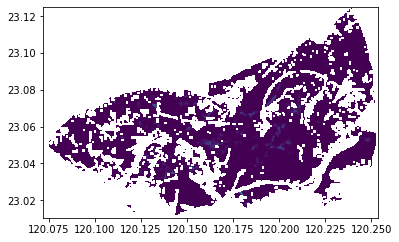

In [3]:
with rasterio.open(out_path) as src:
    rasterio.plot.show(src)

In [4]:
#!
# 迭代各dataframe 回傳經緯度min/max (minx/maxx/miny/maxy)
bound = [9999, 0, 9999 , 0] # 預設值
for df in df_set:
    bounds = df.geometry.bounds
    # 檢查各值 符合條件(更大的框)則更新
    bound = [min(bounds.minx) if min(bounds.minx)<bound[0] else bound[0], # 最小經度
             max(bounds.maxx) if max(bounds.maxx)>bound[1] else bound[1], # 最大經度
             min(bounds.miny) if min(bounds.miny)<bound[2] else bound[2], # 最小緯度
             max(bounds.maxy) if max(bounds.maxy)>bound[3] else bound[3]] # 最大緯度
margin_lng = (bound[0] - bound[1]) * 0.03
margin_lat = (bound[2] - bound[3]) * 0.03
#bound = list(map(lambda x, y: x + y, bound, [-margin_lng, +margin_lng, -margin_lat, +margin_lat]))
print(bound)

[118.13797245900003, 124.56114950000006, 21.895599675000085, 26.385278130000074]


In [5]:
def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

In [6]:
def getBoundsZoomLevel(bound, mapDim):
    WORLD_DIM = { "height": 256,
                  "width": 256 }
    ZOOM_MAX = 20

    def latRad(lat) :
        sin = math.sin(lat * math.pi / 180)
        radX2 = math.log((1 + sin) / (1 - sin)) / 2
        return max(min(radX2, math.pi), -math.pi) / 2

    def zoom(mapPx, worldPx, fraction):
        return math.floor(math.log(mapPx / worldPx / fraction) / math.log(2))
    # 計算採用googlemap格式 (緯度,經度)
    # 右上
    ne = {"lat": bound[3],
          "lng": bound[1]}
    # 左下
    sw = {"lat": bound[2],
          "lng": bound[0]}

    latFraction = (latRad(ne["lat"]) - latRad(sw["lat"])) / math.pi

    lngDiff = ne["lng"] - sw["lng"]
    lngFraction = ((lngDiff + 360) / 360) if lngDiff < 0 else (lngDiff / 360)

    latZoom = zoom(mapDim["height"], WORLD_DIM["height"], latFraction)
    lngZoom = zoom(mapDim["width"], WORLD_DIM["width"], lngFraction)

    return min(latZoom, lngZoom, ZOOM_MAX)

計算最佳zoom_level:  8
耗時14.8秒


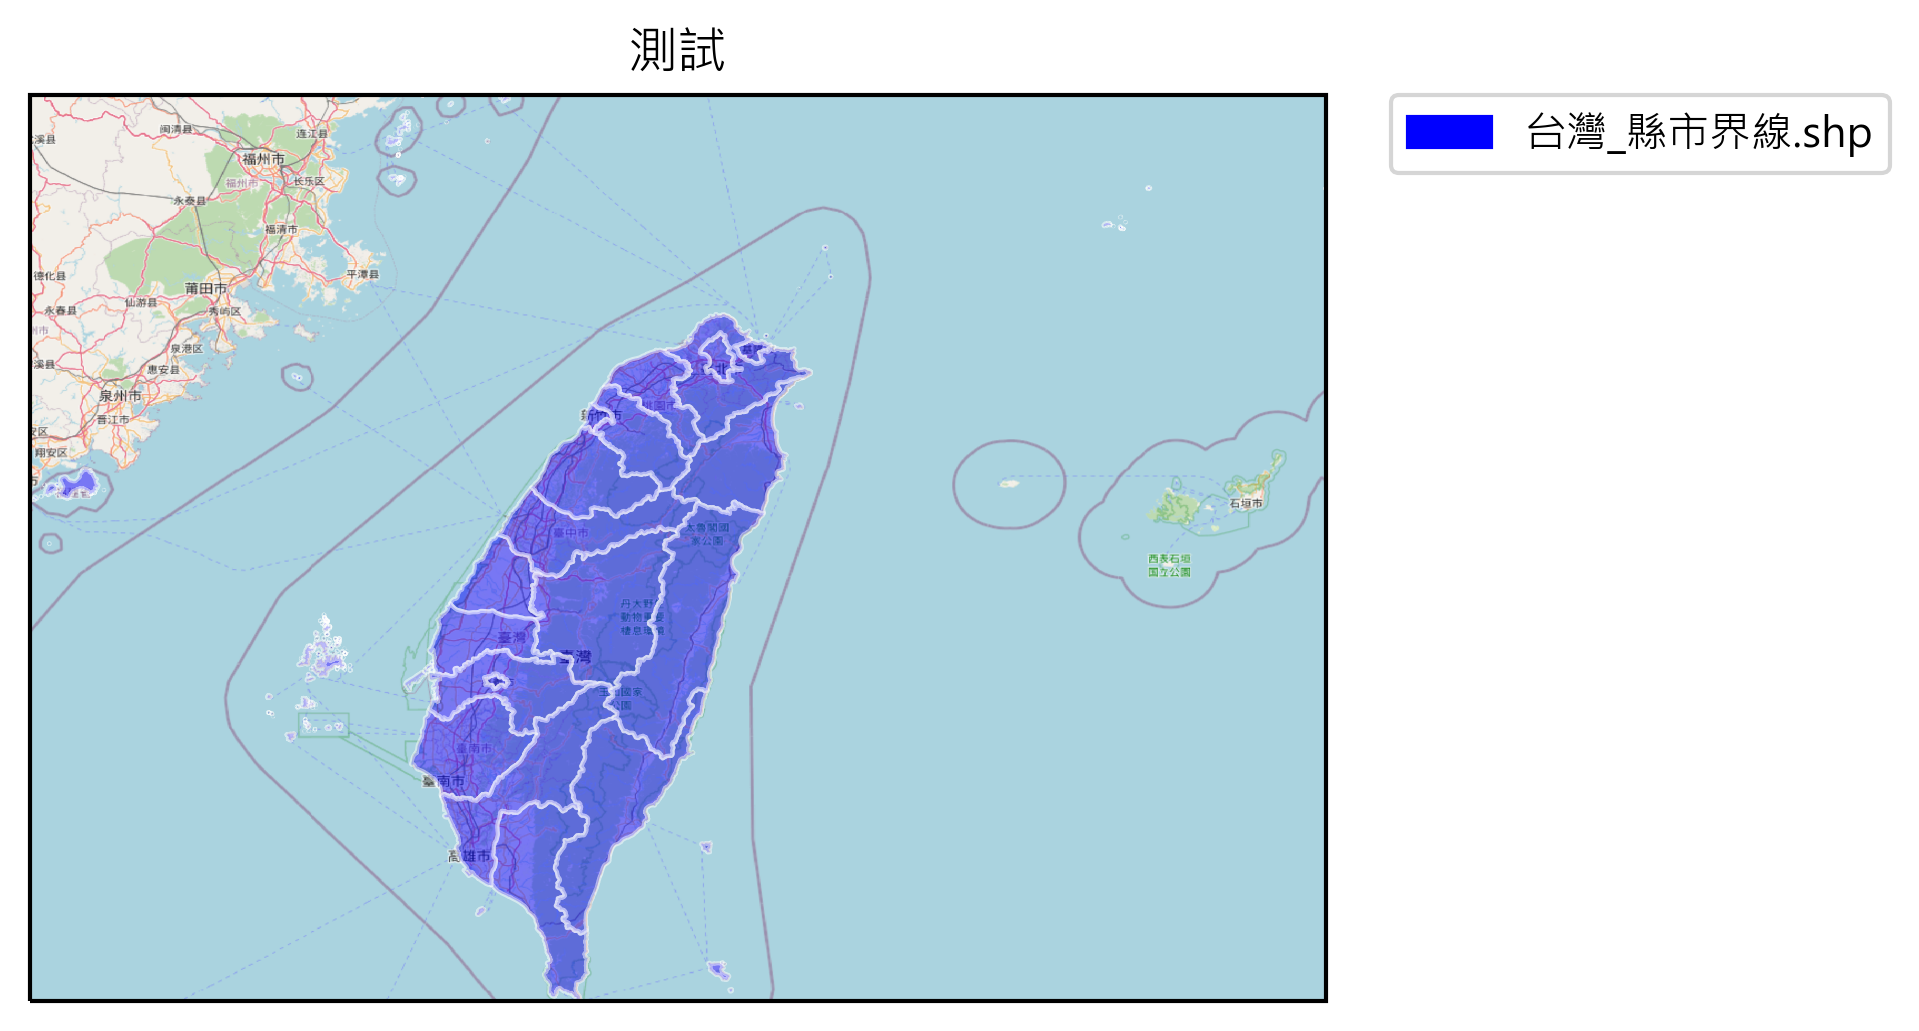

In [7]:
# fig與legend固定4比1
# 字體大小12pt
# legend超出則裁切
# 解決matplotlib本身不支援中文字體 會顯示成方塊的問題
# 參見： https://stackoverflow.com/questions/10960463/non-ascii-characters-in-matplotlib
plt.rcParams['axes.unicode_minus'] = False # 解決負號 '-' 顯示為方塊的問題
plt.rc('font', **{'sans-serif' : 'Microsoft JhengHei', # 指定中文字體 (微軟正黑體)
                  'family' : 'sans-serif'}) # 指定默認字型
dpi = 300
fig = plt.figure(dpi=dpi)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_title("測試")
ax.set_extent(bound, ccrs.PlateCarree())
# 獲取fig框像素大小
fig_size = fig.get_size_inches()*fig.dpi
mapDim = { "height": int(fig_size[0]),
           "width":  int(fig_size[1])}
# 計算zoom_level
zoom_lv = getBoundsZoomLevel(bound, mapDim)
print("計算最佳zoom_level: ", zoom_lv)

OSM.get_image = new_get_image
imagery = OSM()

# interpolation: matplotlib抗鋸齒
# 待0.18.1發佈更新 可修正下述bug
# cartopy0.18版interpolation有bug
# 參見: https://github.com/SciTools/cartopy/issues/1563
# cartopy0.17版add_image有bug
# 參見: https://github.com/SciTools/cartopy/issues/1341

inter = 'spline36'
# regrid_shape: basemap長寬之短邊尺寸
regrid = max(mapDim.values())
#ax.add_image(imagery, zoom, interpolation=inter, regrid_shape=regrid)
ax.add_image(imagery, zoom_lv, regrid_shape=regrid)
# 色碼表： https://www.ebaomonthly.com/window/photo/lesson/colorList.htm

patchs = []
data_set = df_set + raster_set
for i, (label, color, data) in enumerate(zip(file_set, color_set, data_set)):
    # vector檔
    if i < len(df_set):
        if sum(data.geom_type == 'Point') != 0:
            ax.scatter([point.x for point in data.geometry],
                       [point.y for point in data.geometry],
                       s=[2 for j in range(len(data.geometry))], # s = size:控制每個點大小的list
                       c=color,
                       alpha=0.6,
                       transform=ccrs.PlateCarree(),
                       zorder=2) # Zorder:大的在上面
        elif sum(data.geom_type == 'MultiPoint') != 0:
            for points in data.geometry:
                ax.scatter([point.x for point in points],
                           [point.y for point in points],
                           s=[2 for i in range(len(data.geometry))],
                           c=color,
                           alpha=0.6,
                           transform=ccrs.PlateCarree(),
                           zorder=2)
        else: # polygon
            c='blue'
            # add_geomrtries把資料視為polygon匯入 若是point add後會沒有東西
            ax.add_geometries(data.geometry,
                              ccrs.PlateCarree(),
                              edgecolor='white',
                              facecolor=color,
                              alpha=0.5,
                              zorder=1)
        # plt.plot的圖例可指定實例讓handles自動生成
        # add_geometries的圖例需透過mpatches.Patch
        patchs.append(mpatches.Patch(color=color,
                                     label=label))
    # raster檔
    else:
        with rasterio.open(data) as src:
            rasterio.plot.show(src, ax=ax)

lg = plt.legend(handles=patchs,
                bbox_to_anchor=(1.05, 1), # (0,0):座標軸左下角 ; (1,1):座標軸右上角
                loc='upper left',
                borderaxespad=0.
                )
st = time.time()
plt.savefig('./output/result.jpg',
            dpi=dpi,
            #!
            # 防止圖例轉圖像時被裁剪
            #bbox_extra_artists=(lg,),
            #bbox_inches='tight'
            )
et = time.time() - st
print("耗時{:.1f}秒".format(et))
plt.show()